CoNLL-2003 dataset task demonstrates the labeling of tokens for named entity recognition (NER), part-of-speech (POS) tagging, and chunking. Each component of the JSON object corresponds to a different layer of annotation for the sentence:

1. **Tokens**: These are the individual words or punctuation marks from the text. In this case, the sentence "EU rejects German call to boycott British lamb." is split into tokens:
   - "EU"
   - "rejects"
   - "German"
   - "call"
   - "to"
   - "boycott"
   - "British"
   - "lamb"
   - "."

2. **POS Tags**: This array contains the POS tags corresponding to each token. The tags are encoded as numbers, each representing a specific part of speech (like noun, verb, adjective). These numbers usually correspond to a tagging scheme such as the Penn Treebank POS tags:
   - "EU" is tagged as 22, which represents a proper noun.
   - "rejects" is tagged as 42, indicating a verb in present tense.
   - And so forth.

3. **Chunk Tags**: This array indicates phrase chunk boundaries and types (like NP for noun phrase, VP for verb phrase). Each number again corresponds to a specific type of phrase or boundary in a predefined scheme:
   - "EU" is part of a noun phrase, hence 11.
   - "rejects" begins a verb phrase, indicated by 21.
   - The chunk tags help in parsing the sentence into linguistically meaningful phrases.

4. **NER Tags**: These tags are used for named entity recognition. They identify whether each token is part of a named entity (like a person, location, organization) and the type of entity:
   - "EU" is tagged as 3, denoting an organization.
   - "German" and "British" are tagged as 7, indicating nationality or ethnicity.
   - Other tokens are tagged as 0, meaning they are not recognized as part of any named entity.

 Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

In [28]:
!pip install uv
!pip install numpy pandas torch torchmetrics datasets scikit-learn umap-learn matplotlib seaborn

# Instructions 
1. download the **conll2003** from the following [link]("https://data.deepai.org/conll2003.zip")
2. unzip the file
3. download the glove embeddings from [link]("https://huggingface.co/datasets/SLU-CSCI4750/glove.6B.100d.txt/resolve/main/glove.6B.100d.txt.gz")
4. unzip the glove embeddings file
5. update the constants in the code below to point to the correct file paths on your machine

In [51]:
# basic imports
import os
import sys
import urllib.request
import zipfile
import gzip
import io

# basic python data science tooling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datasets import (
    Dataset, 
    DatasetDict, 
    Features, 
    Sequence, 
    ClassLabel, 
    Value,
)

# progress bar
from tqdm import tqdm


# deep learning stuff
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy, F1Score, Precision, Recall


# constants for config
if sys.platform == 'win32':  # Windows
    OS_PLATFORM = 'windows'
    CONLL2003_PATH = r"C:/Users/marku/Downloads/conll2003"
    GLOVE_EMBEDS_PATH = r'C:/Users/marku/Downloads/glove.6B.100d.txt'
elif sys.platform == 'darwin':  # macOS
    OS_PLATFORM = 'macOS'
    CONLL2003_PATH = "/Users/markus/Downloads/conll2003"
    GLOVE_EMBEDS_PATH = '/Users/markus/Downloads/glove.6B.100d.txt'
elif sys.platform == 'linux':  # Linux
    OS_PLATFORM = 'linux'
    CONLL2003_PATH = False
    GLOVE_EMBEDS_PATH = False

print(f"Running on {OS_PLATFORM}, using CONLL2003_PATH: {CONLL2003_PATH} and GLOVE_EMBEDS_PATH: {GLOVE_EMBEDS_PATH}")

Running on linux, using CONLL2003_PATH: False and GLOVE_EMBEDS_PATH: False


In [10]:
conll2003_url = "https://data.deepai.org/conll2003.zip"
glove_embeds_url = "https://huggingface.co/datasets/SLU-CSCI4750/glove.6B.100d.txt/resolve/main/glove.6B.100d.txt.gz"

def download_and_load_conll2003(url):
    """Download CoNLL-2003 zip, extract files into memory, and return file contents."""
    with urllib.request.urlopen(url) as response:
        zip_data = response.read()
    files_content = {}
    with zipfile.ZipFile(io.BytesIO(zip_data), 'r') as zip_ref:
        for filename in zip_ref.namelist():
            if filename.endswith('.txt'):
                with zip_ref.open(filename) as f:
                    files_content[filename] = f.read().decode('utf-8')
    return files_content

def download_and_load_glove(url):
    """Download GloVe embeddings gz file and load into memory."""
    with urllib.request.urlopen(url) as response:
        gz_data = response.read()
    with gzip.GzipFile(fileobj=io.BytesIO(gz_data)) as f:
        glove_text = f.read().decode('utf-8')    
    return glove_text


conll_files = download_and_load_conll2003(conll2003_url)
glove_data = download_and_load_glove(glove_embeds_url)


print(f"CoNLL-2003 files loaded: {list(conll_files.keys())}")
print(f"GloVe embeddings loaded: {len(glove_data.splitlines())} words")

CoNLL-2003 files loaded: ['test.txt', 'train.txt', 'valid.txt']
GloVe embeddings loaded: 400000 words


In [ ]:
train_file = os.path.join(CONLL2003_PATH, "train.txt") if CONLL2003_PATH else None
valid_file = os.path.join(CONLL2003_PATH, "valid.txt") if CONLL2003_PATH else None
test_file = os.path.join(CONLL2003_PATH, "test.txt") if CONLL2003_PATH else None

pos_names = [
    '"',
    "''",
    "#",
    "$",
    "(",
    ")",
    ",",
    ".",
    ":",
    "``",
    "CC",
    "CD",
    "DT",
    "EX",
    "FW",
    "IN",
    "JJ",
    "JJR",
    "JJS",
    "LS",
    "MD",
    "NN",
    "NNP",
    "NNPS",
    "NNS",
    "NN|SYM",
    "PDT",
    "POS",
    "PRP",
    "PRP$",
    "RB",
    "RBR",
    "RBS",
    "RP",
    "SYM",
    "TO",
    "UH",
    "VB",
    "VBD",
    "VBG",
    "VBN",
    "VBP",
    "VBZ",
    "WDT",
    "WP",
    "WP$",
    "WRB",
]

chunk_names = [
    "O",
    "B-ADJP",
    "I-ADJP",
    "B-ADVP",
    "I-ADVP",
    "B-CONJP",
    "I-CONJP",
    "B-INTJ",
    "I-INTJ",
    "B-LST",
    "I-LST",
    "B-NP",
    "I-NP",
    "B-PP",
    "I-PP",
    "B-PRT",
    "I-PRT",
    "B-SBAR",
    "I-SBAR",
    "B-UCP",
    "I-UCP",
    "B-VP",
    "I-VP",
]

ner_names = [
    "O",
    "B-PER",
    "I-PER",
    "B-ORG",
    "I-ORG",
    "B-LOC",
    "I-LOC",
    "B-MISC",
    "I-MISC",
]


def parse_conll(path: str = None, text_content: str = None):
    """Parse a CoNLL-2003 file or text content into a list of examples."""
    examples = []
    tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
    
    # Determine source: file path or text content
    if text_content is not None:
        lines = text_content.splitlines()
    elif path is not None:
        with open(path, encoding="utf-8") as f:
            lines = f.readlines()
    else:
        raise ValueError("Either path or text_content must be provided")
    
    for line in lines:
        if line.startswith("-DOCSTART-") or line.strip() == "":
            if tokens:
                examples.append(
                    {
                        "tokens": tokens,
                        "pos_tags": pos_tags,
                        "chunk_tags": chunk_tags,
                        "ner_tags": ner_tags,
                    }
                )
                tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
        else:
            splits = line.rstrip().split(" ")
            tokens.append(splits[0])
            pos_tags.append(splits[1])
            chunk_tags.append(splits[2])
            ner_tags.append(splits[3])
    
    if tokens:
        examples.append(
            {
                "tokens": tokens,
                "pos_tags": pos_tags,
                "chunk_tags": chunk_tags,
                "ner_tags": ner_tags,
            }
        )
    return examples



def as_dataset(examples, features: Features):
    ids = []
    tokens_col, pos_col, chunk_col, ner_col = [], [], [], []
    for i, ex in enumerate(examples):
        ids.append(str(i))
        tokens_col.append(ex["tokens"])
        pos_col.append(ex["pos_tags"])
        chunk_col.append(ex["chunk_tags"])
        ner_col.append(ex["ner_tags"])
    return Dataset.from_dict(
        {
            "id": ids,
            "tokens": tokens_col,
            "pos_tags": pos_col,
            "chunk_tags": chunk_col,
            "ner_tags": ner_col,
        },
        features=features,
    )


features = Features(
    {
        "id": Value("string"),
        "tokens": Sequence(Value("string")),
        "pos_tags": Sequence(ClassLabel(names=pos_names)),
        "chunk_tags": Sequence(ClassLabel(names=chunk_names)), # entities --> several tokens forming a single entity phrase e.g. "New York"
        "ner_tags": Sequence(ClassLabel(names=ner_names)),
    }
)


if CONLL2003_PATH:  # Windows or macOS - use file paths
    train_examples = parse_conll(path=train_file)
    valid_examples = parse_conll(path=valid_file)
    test_examples = parse_conll(path=test_file)
else:  # Linux - use in-memory data on jupyter server
    train_examples = parse_conll(text_content=conll_files['train.txt'])
    valid_examples = parse_conll(text_content=conll_files['valid.txt'])
    test_examples = parse_conll(text_content=conll_files['test.txt'])

conll2003 = DatasetDict(
    {
        "train": as_dataset(train_examples, features),
        "validation": as_dataset(valid_examples, features),
        "test": as_dataset(test_examples, features),
    }
)

display(conll2003)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [20]:
print(conll2003['train'][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [22]:
def load_glove_embeddings(file_path=None, text_content=None, embedding_dim=100):
    """Load GloVe embeddings from file path or text content."""
    word_vectors = {}
    if text_content is not None:
        lines = text_content.splitlines()
    elif file_path is not None:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    else:
        raise ValueError("Either file_path or text_content must be provided")
    for line in lines:
        values = line.split()
        word = values[0]
        vector = torch.tensor(
            [float(val) for val in values[1:]], dtype=torch.float32)
        word_vectors[word] = vector
    vocab_size = len(word_vectors)
    embedding_matrix = torch.zeros((vocab_size, embedding_dim))
    word_to_idx = {}
    idx_to_word = {}
    for i, (word, vector) in enumerate(word_vectors.items()):
        embedding_matrix[i] = vector
        word_to_idx[word] = i
        idx_to_word[i] = word
    return embedding_matrix, word_to_idx, idx_to_word


embedding_dim = 100

if GLOVE_EMBEDS_PATH:  # Windows or macOS - use file path
    embedding_matrix, word_to_idx, idx_to_word = load_glove_embeddings(
        file_path=GLOVE_EMBEDS_PATH, 
        embedding_dim=embedding_dim
    )
else:  # Linux - use in-memory data
    embedding_matrix, word_to_idx, idx_to_word = load_glove_embeddings(
        text_content=glove_data, 
        embedding_dim=embedding_dim
    )

embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
embedding_layer

Embedding(400000, 100)

In [58]:
UNK_IDX = len(word_to_idx)
PADDING_TOKEN_VALUE = -100

def tokens_to_indices(tokens_batch):
    indices = []
    for tokens in tokens_batch:
        idxs = [
            word_to_idx.get(t.lower(), UNK_IDX) for t in tokens
        ]
        indices.append(torch.tensor(idxs, dtype=torch.long))
    return indices


def labels_to_tensors(labels_batch):
    return [torch.tensor(lbls, dtype=torch.long) for lbls in labels_batch]


def collate_fn(batch):
    input_ids = tokens_to_indices([b["tokens"] for b in batch])
    labels = labels_to_tensors([b["ner_tags"] for b in batch])
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=UNK_IDX)
    labels = pad_sequence(labels, batch_first=True, padding_value=PADDING_TOKEN_VALUE)
    tokens = [b["tokens"] for b in batch]
    return {
        "input_ids": input_ids, 
        "labels": labels,
        "tokens": tokens  # Include for debugging/evaluation
    }


train_dataloader = DataLoader(conll2003["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(conll2003["validation"], batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(conll2003["test"], batch_size=32, collate_fn=collate_fn)

In [60]:
for batch in train_dataloader:
    print(batch['tokens'])
    break

[['Gary', 'Orr', ',', 'Jose-Maria', 'Canizares', '(', 'Spain', ')', ',', 'Michael', 'Jonzon'], ['Jason', 'Wong', '(', 'Malaysia', ')', 'beat', 'Abdul', 'Samad', 'Ismail', '(', 'Malaysia', ')', '16-18'], ['Exeter', '1', 'Doncaster', '1'], ['For', 'Sept', '20', '-', 'Oct', '10', ':', '19,500', 'of', 'DNS', 'at', '$', '212.25', ',', '10,000', 'of', 'HRW', 'at', '$', '204.74', ',', '4,500', 'of', 'WW', 'at', '$', '199.71', '.'], ['"', 'They', "'ve", 'got', 'a', 'very', 'sound', 'domestic', 'business', 'which', 'is', 'doing', 'very', 'well', ',', 'we', 'remain', 'positive', 'on', 'the', 'stock', ',', '"', 'said', 'Roe', '.', '"'], ['PSV', 'Eindhoven', '1', '1', '0', '0', '4', '1', '3'], ['Sumitomo', 'and', 'CNIEC', 'have', 'made', 'no', 'comments', 'on', 'the', 'talk', 'and', 'Chinese', 'traders', 'said', 'they', 'know', 'nothing', 'of', 'such', 'an', 'arrangement', '.'], ['drawn', ',', 'lost', ',', 'winning', 'percentage', ',', 'games', 'behind', 'first', 'place', ')'], ['Fastest', 'lap', 

# 1 Linear Layer

Training: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it, loss=0.128, val_loss=0.262]


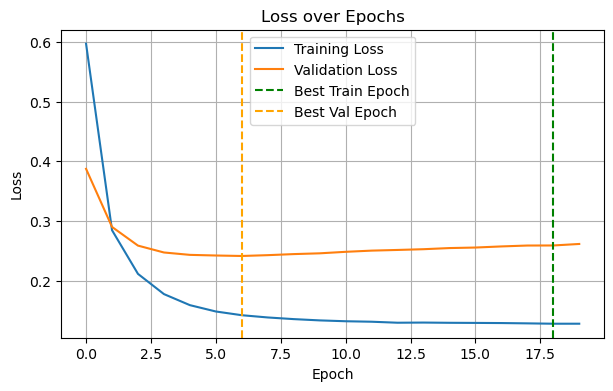

In [ ]:

class LinearNER(nn.Module):
    def __init__(self, embedding_matrix: torch.Tensor, num_tags: int):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)  # +1 for UNK
        # Initialize known GloVe rows; last row (index vocab_size) is UNK ~ zeros
        with torch.no_grad():
            # copy glove embeddings into the embedding matrix weights
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()
        self.classifier = nn.Linear(embed_dim, num_tags)

    def forward(self, input_ids):
        emb = self.embedding(input_ids)           # (B, T, D)
        logits = self.classifier(emb)             # (B, T, C)
        return logits


num_tags = len(conll2003["train"].features["ner_tags"].feature.names)
model = LinearNER(embedding_matrix, num_tags)
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_VALUE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
f1_scorer = F1Score(task='multiclass', num_classes=num_tags, average='macro').to(device)


def plot_loss(train_loss_history=None, val_loss_history=None, best_train_epoch=None, best_val_epoch=None, title=None):
    plt.figure(figsize=(7, 4))
    assert train_loss_history is not None or val_loss_history is not None, "At least one loss history must be provided."
    if train_loss_history is not None:
        plt.plot(train_loss_history, label='Training Loss')
    if val_loss_history is not None:
        plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title if title is not None else 'Loss over Epochs')
    if best_train_epoch is not None:
        plt.axvline(x=best_train_epoch, color='green', linestyle='--', label='Best Train Epoch')
    if best_val_epoch is not None:
        plt.axvline(x=best_val_epoch, color='orange', linestyle='--', label='Best Val Epoch')
    plt.legend()
    plt.grid()
    plt.show()

# Train the model (simple few epochs)
num_epochs = 20
best_train_loss, best_val_loss = float('inf'), float('inf')
best_model_params = None
best_train_epoch, best_val_epoch = None, None
best_f1 = 0.0
train_loss_history, val_loss_history = [], []
pbar = tqdm(range(num_epochs), desc="Training")
for epoch in pbar:
    model.train()
    total_train_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device) # NER labels
        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        # f1_score = f1_scorer(logits.view(-1, num_tags), labels.view(-1))
        # pbar.set_postfix({"f1_score": best_f1.item()})
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)
    if total_train_loss < best_train_loss:
        best_train_loss = total_train_loss
        best_model_params = model.state_dict()
        best_train_epoch = epoch

    # Validate the model
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            logits = model(input_ids)
            loss = criterion(logits.view(-1, num_tags), labels.view(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_val_epoch = epoch

    pbar.set_postfix({"loss": avg_train_loss, "val_loss": avg_val_loss})

plot_loss(
    train_loss_history=train_loss_history, 
    val_loss_history=val_loss_history, 
    best_train_epoch=best_train_epoch, 
    best_val_epoch=best_val_epoch
    )

Test F1 Score: 0.6406


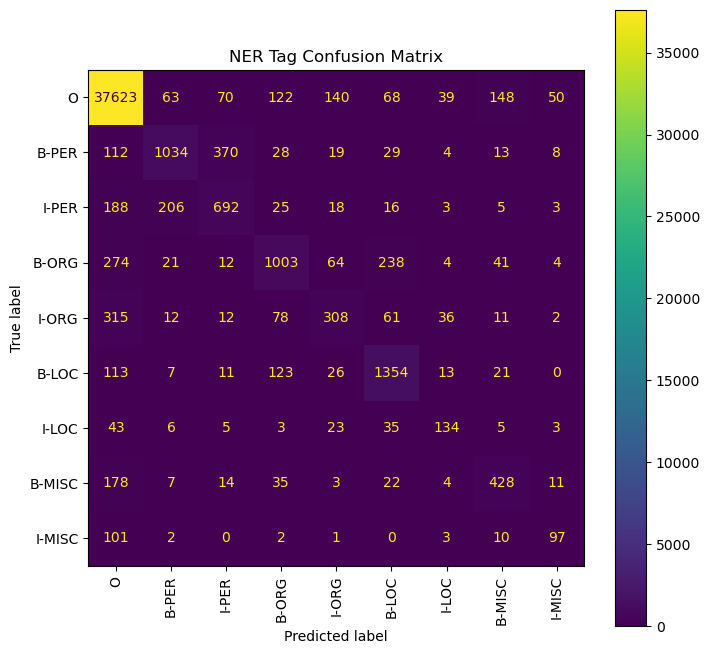

In [53]:
# visualize the conf matrix
best_model = LinearNER(embedding_matrix, num_tags)
best_model.load_state_dict(best_model_params)

f1_scorer = F1Score(task='multiclass', num_classes=num_tags, average='macro')



preds = []
ground_truth = [] 
best_model.eval()
with torch.no_grad():
    total_test_loss = 0.0
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        logits = model(input_ids)
  
        batch_preds = torch.argmax(logits, dim=-1).view(-1)
        batch_labels = labels.view(-1)

        # filter out padding tokens (label == -100)
        mask = batch_labels != PADDING_TOKEN_VALUE
        preds.extend(batch_preds[mask].cpu().numpy())
        ground_truth.extend(batch_labels[mask].cpu().numpy())

print(f"Test F1 Score: {f1_scorer(torch.tensor(preds), torch.tensor(ground_truth)).item():.4f}")

cm = confusion_matrix(ground_truth, preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=conll2003["train"].features["ner_tags"].feature.names
    )
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("NER Tag Confusion Matrix"); plt.show()

# 2 MLP

In [64]:
class MLP(nn.Module):
    def __init__(self, 
                 embedding_matrix: torch.Tensor, 
                 num_tags: int, 
                 hidden_layers: int = 2, 
                 hidden_dim: int = 128,
                 activation_fn: nn.Module = nn.Identity(),
                 dropout: float = 0.0,
                 batch_norm: bool = False,
                ):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.hidden_layers = hidden_layers
        self.hidden_dim = hidden_dim
        self.batch_norm = batch_norm
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)  # +1 for UNK
        # Initialize known GloVe rows; last row (index vocab_size) is UNK ~ zeros
        with torch.no_grad():
            # copy glove embeddings into the embedding matrix weights
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()

        self.in_layer = nn.Linear(embed_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, num_tags)
        self.hid_layers = []
        for _ in range(hidden_layers):
            self.hid_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.hid_layers.append(activation_fn)
            self.hid_layers.append(activation_fn)
            if dropout > 0.0:
                self.hid_layers.append(nn.Dropout(dropout))
        self.net = nn.Sequential(
            self.in_layer,
            *self.hid_layers,
            self.out_layer
        )

    def forward(self, input_ids):
        emb = self.embedding(input_ids) # (B, T, D)
        if self.batch_norm:
            x = self.in_layer(emb)  # (B, T, H)
            batchnorms = [nn.BatchNorm1d(self.hidden_dim) for _ in range(self.hidden_layers)]
            for lay, actfc, batchnorm in zip(self.hid_layers[::3], self.hid_layers[1::3], batchnorms):
                x = lay(x)
                x = actfc(x)
                batch_size, seq_len, hidden_dim = x.shape # (B, T, H)
                x = x.transpose(1, 2)  # (B, H, T)
                x = batchnorm(x)
                x = x.transpose(1, 2)  # (B, T, H)
                x = actfc(x)
            logits = self.out_layer(x)
            return logits
        else:
            x = self.net(x)
        logits = self.net(emb)
        return logits




CONFIGS = [
    {
        "hidden_layers": 2,
        "hidden_dim": 128,
        "activation_fn": nn.Identity(),
        "dropout": 0.0,
        "batch_norm": True,
    },
    {
        "hidden_layers": 2,
        "hidden_dim": 256,
        "activation_fn": nn.Identity(),
        "dropout": 0.0,
        "batch_norm": False,
    },
    {
        "hidden_layers": 4,
        "hidden_dim": 128,
        "activation_fn": nn.Identity(),
        "dropout": 0.0,
        "batch_norm": False,
    },
    {
        "hidden_layers": 4,
        "hidden_dim": 256,
        "activation_fn": nn.Identity(),
        "dropout": 0.0,
        "batch_norm": False,
    },

]

num_tags = len(conll2003["train"].features["ner_tags"].feature.names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_VALUE)
num_epochs = 20
best_overall_train_loss = float('inf')
best_overall_model_params = None

for CONFIG in CONFIGS:
    model = MLP(embedding_matrix, num_tags, **CONFIG)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)


    best_train_loss, best_val_loss = float('inf'), float('inf')
    best_model_params = None
    best_train_epoch, best_val_epoch = None, None
    best_f1 = 0.0
    train_loss_history, val_loss_history = [], []
    pbar = tqdm(range(num_epochs), desc="Training")
    for epoch in pbar:
        model.train()
        total_train_loss = 0.0
        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device) # NER labels
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, num_tags), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)
        if total_train_loss < best_train_loss:
            best_train_loss = total_train_loss
            best_model_params = model.state_dict()
            best_train_epoch = epoch

        # Validate the model
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                logits = model(input_ids)
                loss = criterion(logits.view(-1, num_tags), labels.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            best_val_epoch = epoch

        pbar.set_postfix({"loss": avg_train_loss, "val_loss": avg_val_loss})
    
    if best_train_loss < best_overall_train_loss:
        best_overall_train_loss = best_train_loss
        best_overall_model_params = best_model_params

    plot_loss(
        train_loss_history=train_loss_history, 
        val_loss_history=val_loss_history, 
        best_train_epoch=best_train_epoch, 
        best_val_epoch=best_val_epoch,
        title=f"Hidden Layers: {CONFIG['hidden_layers']} | Hidden Dim: {CONFIG['hidden_dim']}"
        )

Training:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but got weight is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__cudnn_batch_norm)

In [ ]:
f1_scorer = F1Score(task='multiclass', num_classes=num_tags, average='macro')
precision_scorer = Precision(task='multiclass', num_classes=num_tags, average='macro')
recall_scorer = Recall(task='multiclass', num_classes=num_tags, average='macro')

best_model = MLP(embedding_matrix, num_tags, **CONFIG)
best_model.load_state_dict(best_overall_model_params)

preds = []
ground_truth = [] 
best_model.eval()
with torch.no_grad():
    total_test_loss = 0.0
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        logits = model(input_ids)
  
        batch_preds = torch.argmax(logits, dim=-1).view(-1)
        batch_labels = labels.view(-1)

        # filter out padding tokens (label == -100)
        mask = batch_labels != PADDING_TOKEN_VALUE
        preds.extend(batch_preds[mask].cpu().numpy())
        ground_truth.extend(batch_labels[mask].cpu().numpy())

print(f"Test F1 Score: {f1_scorer(torch.tensor(preds), torch.tensor(ground_truth)).item():.4f}")
print(f"Test Precision Score: {precision_scorer(torch.tensor(preds), torch.tensor(ground_truth)).item():.4f}")
print(f"Test Recall Score: {recall_scorer(torch.tensor(preds), torch.tensor(ground_truth)).item():.4f}")

cm = confusion_matrix(ground_truth, preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=conll2003["train"].features["ner_tags"].feature.names
    )
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("NER Tag Confusion Matrix"); plt.show()

NameError: name 'best_overall_model_params' is not defined

# 3. Activation Funcs

In [ ]:
CONFIGS = [
    {
        "hidden_layers": 2,
        "hidden_dim": 128,
        "activation_fn": nn.ReLU(),
        "dropout": 0.0,
        "batch_norm": False,
    },
    {
        "hidden_layers": 2,
        "hidden_dim": 256,
        "activation_fn": nn.Tanh(),
        "dropout": 0.0,
        "batch_norm": False,
    },
    {
        "hidden_layers": 4,
        "hidden_dim": 128,
        "activation_fn": nn.Sigmoid(),
        "dropout": 0.0,
        "batch_norm": False,
    },

]

num_tags = len(conll2003["train"].features["ner_tags"].feature.names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_VALUE)
num_epochs = 20

for CONFIG in CONFIGS:
    break
    model = MLP(embedding_matrix, num_tags, **CONFIG)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)


    best_train_loss, best_val_loss = float('inf'), float('inf')
    best_model_params = None
    best_train_epoch, best_val_epoch = None, None
    best_f1 = 0.0
    train_loss_history, val_loss_history = [], []
    pbar = tqdm(range(num_epochs), desc="Training")
    for epoch in pbar:
        model.train()
        total_train_loss = 0.0
        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device) # NER labels
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, num_tags), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)
        if total_train_loss < best_train_loss:
            best_train_loss = total_train_loss
            best_model_params = model.state_dict()
            best_train_epoch = epoch

        # Validate the model
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                logits = model(input_ids)
                loss = criterion(logits.view(-1, num_tags), labels.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            best_val_epoch = epoch

        pbar.set_postfix({"loss": avg_train_loss, "val_loss": avg_val_loss})

    plot_loss(
        train_loss_history=train_loss_history, 
        val_loss_history=val_loss_history, 
        best_train_epoch=best_train_epoch, 
        best_val_epoch=best_val_epoch
        )

# Regularization (Dropout/BatchNorm)

In [ ]:
CONFIGS = [
    {
        "hidden_layers": 2,
        "hidden_dim": 128,
        "activation_fn": nn.ReLU(),
        "dropout": 0.0,
        "batch_norm": False,
    },
    {
        "hidden_layers": 2,
        "hidden_dim": 256,
        "activation_fn": nn.Tanh(),
        "dropout": 0.0,
        "batch_norm": False,
    },
    {
        "hidden_layers": 4,
        "hidden_dim": 128,
        "activation_fn": nn.Sigmoid(),
        "dropout": 0.0,
        "batch_norm": False,
    },

]

num_tags = len(conll2003["train"].features["ner_tags"].feature.names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_VALUE)
num_epochs = 20

for CONFIG in CONFIGS:
    model = MLP(embedding_matrix, num_tags, **CONFIG)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)


    best_train_loss, best_val_loss = float('inf'), float('inf')
    best_model_params = None
    best_train_epoch, best_val_epoch = None, None
    best_f1 = 0.0
    train_loss_history, val_loss_history = [], []
    pbar = tqdm(range(num_epochs), desc="Training")
    for epoch in pbar:
        model.train()
        total_train_loss = 0.0
        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device) # NER labels
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, num_tags), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)
        if total_train_loss < best_train_loss:
            best_train_loss = total_train_loss
            best_model_params = model.state_dict()
            best_train_epoch = epoch

        # Validate the model
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                logits = model(input_ids)
                loss = criterion(logits.view(-1, num_tags), labels.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            best_val_epoch = epoch

        pbar.set_postfix({"loss": avg_train_loss, "val_loss": avg_val_loss})

    plot_loss(
        train_loss_history=train_loss_history, 
        val_loss_history=val_loss_history, 
        best_train_epoch=best_train_epoch, 
        best_val_epoch=best_val_epoch
        )